# Generative Adversarial Networks for number generation
First we import the libraries

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import os
import cv2
import numpy as np
from tqdm import tqdm
import glob

We can set a variable **device** that directs to our GPU in case that we have one available in our computer. The following will assign the GPU to **device** in case that we have one, otherwise the device will point to the CPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Now, we need to load all the images of numbers from the numbers file in the same folder (after we decompressed the file). The array obtained can be saved in a file in order to access it easier next time

In [9]:
IMG_SIZE = 64
images = []
for img in tqdm(glob.glob("numbers/*.png")):
    n = cv2.imread(img, cv2.IMREAD_COLOR)
    n = cv2.resize(n, (IMG_SIZE, IMG_SIZE))
    n = np.asarray(n.transpose(2,0,1))
    images.append(n)
# Save the array
np.save("training_dat.npy", images)

100%|██████████| 10000/10000 [00:02<00:00, 3354.53it/s]


The loaded array is indeed an array with 10000 MNIST number of 64x64 pixels. We also have three channels of color (BGR), although since the image is in black and white, we could use only one channel, but this way we can tackle problems that can appear when treating images with more than one channel

In [11]:
np.shape(images)

(10000, 3, 64, 64)

We can plot examples of our images

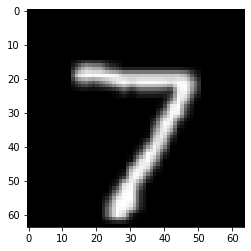

In [12]:
import matplotlib.pyplot as plt
# We use the transpose to switch the dimensions of the NumPy array so that the plt.imshow displays it correctly
plt.imshow(images[0].transpose(1,2,0))

To load the array we just need to use the following line

In [14]:
training_data = np.load("training_dat.npy", allow_pickle=True)
np.shape(training_data)

(10000, 3, 64, 64)

Now we need to normalise the array between -1 and 1 and create a PyTorch tensor with it. We can check if the tensor created is stored in the GPU or not with **is_cuda**

In [15]:
# Change to pytorch tensor format
X = torch.Tensor([((i/255.)*2 - 1) for i in tqdm(training_data)]).to(device)
print(X.is_cuda)

100%|██████████| 10000/10000 [00:00<00:00, 20668.28it/s]


False


The next step is defining the Generator and Discriminator neural networks. They will be made of convolutional layers. We also create a function to initialise the parameters of the networks sampling a normal distribution

In [17]:
# Create the Generator and Discriminator Neural Networks

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
class G(nn.Module):
    def __init__(self):
            super(G, self).__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace = True),
                nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace = True),
                nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace = True),
                nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace = True),
                nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
                nn.Tanh()
            )
    def forward(self, input):
            output = self.main(input)
            return output
netG = G()
netG.apply(weights_init)
class D(nn.Module):
    def __init__(self):
            super(D, self).__init__()
            self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, 2, 1, bias = False),
                nn.LeakyReLU(0.2, inplace = True),
                nn.Conv2d(64, 128, 4, 2, 1, bias = False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace = True),
                nn.Conv2d(128, 256, 4, 2, 1, bias = False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace = True),
                nn.Conv2d(256, 512, 4, 2, 1, bias = False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace = True),
                nn.Conv2d(512, 1, 4, 1, 0, bias = False),
                nn.Sigmoid()
            )
    def forward(self, input):
            output = self.main(input)
            return output.view(-1)
netD = D()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

The next step is defining the loss function and the optimizers. In this case we will use the Binary Cross Entropy loss

In [18]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

We have to load the neural networks to the GPU in case that we are using one

In [20]:
netD.to(device)
print(next(netD.parameters()).is_cuda)
netG.to(device)
print(next(netG.parameters()).is_cuda)

False
False


In [22]:
EPOCHS = 150
BATCH_SIZE = 64
for epoch in range(0, EPOCHS):
    for i in range(0, len(X), BATCH_SIZE):
        netD.zero_grad()

        real = X[i:i+BATCH_SIZE]
        target = torch.ones(real.size()[0]).to(device)
        output = netD(real)
        errD_real = criterion(output, target)

        noise = torch.randn(real.size()[0], 100, 1, 1).to(device)
        fake = netG(noise)
        target = torch.zeros(real.size()[0]).to(device)
        output = netD(fake.detach())
        errD_fake = criterion(output, target)

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        netG.zero_grad()
        target = torch.ones(real.size()[0]).to(device)
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f. Total images = %d' % (epoch, EPOCHS, (i+BATCH_SIZE)/BATCH_SIZE, len(X)/BATCH_SIZE, errD.data, errG.data, i+BATCH_SIZE), end="\r")
        if i % (53*BATCH_SIZE) == 0:
            torch.save(netD.state_dict(), 'trained_netD_CDimageGAN.pt')
            torch.save(netG.state_dict(), 'trained_netG_CDimageGAN.pt')
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d_%03d.png' % ("./results", epoch, i+BATCH_SIZE), normalize = True)

KeyboardInterrupt: 

The obtained parameters for each neural network can be loaded with the following

In [23]:
netD.load_state_dict(torch.load('trained_netD_CDimageGAN.pt'))
netD.eval()
netG.load_state_dict(torch.load('trained_netG_CDimageGAN.pt'))
netG.eval()

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(6